In [30]:
from RCA import RCA
from iGA import Improved_GA
import numpy as np
from numpy import sqrt
from scipy import special
import sys
import os
sys.path.append(os.path.join(os.path.dirname('__file__'), '..'))
from capacity_estimation.calc_capacity import make_BMI_list 
from modulation.BICM import make_BICM

In [3]:
def Q(EsNo):
    BER=1/2*(1-special.erf(sqrt(EsNo)))
    return BER

#check
#for i in range(0,10):
 #print(Q(10**(i/10)))

In [4]:
def adaptive_BICM_calc(N,M,EsNodB,type):
    BICM_int=np.arange(N,dtype=int) #if type==3 end
        
    if type==4: #random interleave
        BICM_int,_=make_BICM(N,M)
    
    elif type==1 or type==2: #block interleave
        tmp=make_BMI_list(EsNodB,M)
        seq_of_channels=np.argsort(tmp[:len(tmp)//2])
        num_of_channels=len(seq_of_channels)
        #print(seq_of_channels)
        res=np.empty(0,dtype=int)
        for i in seq_of_channels:
            res=np.concatenate([res,BICM_int[i::num_of_channels]])
        BICM_int=res
    
    elif type==3: #no interleave
        pass
    
    else:
        print("error interleaver type!")
        
    return BICM_int

In [5]:
def calc_BLER_monte_carlo(N,K,M,type,design_SNR):
    #make directry name
    home=os.environ['HOME']
    current_directory=home+"/Dropbox/programming/geometric_shaping/polar_code"
    #current_directory=os.getcwd()
    dir_name="monte_carlo_construction"
    dir_name=current_directory+"/"+dir_name
    
    #make filename
    filename="{}QAM_{}_{}".format(M,N,design_SNR)
    
    if type==1:
        filename+="sep"
    elif type==2:
        filename+="_BICM"
    elif type==3:
        pass
    elif type==4:
        filename+="_BICM_rand"
    else:
        print("something wrong")
    
    #if file exists, then load txt file
    filename=dir_name+"/"+filename
    
    try:
        c=np.loadtxt(filename)
    except (OSError,FileNotFoundError):
        return np.nan
    
    #calc BLER
    BER=np.sort(c/10**6)[:K]
    BLER=1-np.prod(1-BER)
    
    return BLER

In [27]:
def calc_C(gamma):
    var=1
    if var==1:
        #J function
       
        sigma=(8*gamma)**(1/2)
        
        sigma_str=1.6363
        a1=-0.0421061
        b1=0.209252
        c1=-0.00640081
        a2=0.00181491
        b2=-0.142675
        c2=-0.0822054
        d2=0.0549608
        
        if sigma <= sigma_str:
            I=a1*sigma**3+b1*sigma**2+c1*sigma
        elif sigma_str < sigma and sigma<=10:
            I=1-np.exp(a2*sigma**3+b2*sigma**2+c2*sigma+d2)
        else:
            I=1
        
        return I

1.4142135623730951


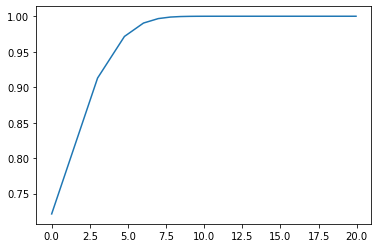

In [28]:
import numpy as np
import matplotlib.pyplot as plt

print(2**(1/2))

x=np.arange(1,100,1)
y=np.zeros(len(x))
for i in range(len(x)):
    y[i]=calc_C(x[i])
    
x=10*np.log10(x)
plt.plot(x,y)

In [29]:
def calc_C_inv(I):
    var=1
    if var==1:
        '''
        input:
        I:mutual information
        output:
        gamma:channel SNR Es/No
        ----
        referrence:
        POLAR CODES FOR ERROR CORRECTION:
        ANALYSIS AND DECODING ALGORITHMS
        p37
        (4.5)
        '''
        if I>1 or I<0:
            print("I is err")
        
        a1=1.09542
        b1=0.214217
        c1=2.33727
        a2=0.706692
        b2=0.386013
        c2=-1.75017
        I_thresh=0.3646
            
        if I<I_thresh:
            sigma=a1*I**2+b1*I+c1*I**(1/2)
        else:
            sigma=-a2*np.log(b2*(1-I))-c2*I
            
        gamma=sigma**2/8
        #gamma_dB=10*math.log10(gamma)
        return gamma
    
    elif var==2:
        def A(c):
            return (-5+24*np.log(2)*c+2*(13+12*np.log(2)*c*(12*np.log(2)*c-5))**(1/2))**(1/3)
    
        def W0(x):
            '''
            Lambert W function
            reference:
            On the lambert W function
            (3.1)
            '''
            def a(n):
                return ((-n)**(n-1)/np.math.factorial(n))*x**n
                
                
            res=0
            for i in range(100):
                res+=a(i)
            return res
        
        if I>1 or I<0:
            print("I is err")
                    
        #print("use new funcß")   
        C1=0.055523
        C2=0.721452
        C3=0.999983
        H21=1.396634
        H22=0.872764
        H23=1.148562
        H31=1.266967
        H32=0.938175
        H33=0.986830
        alpha=1.16125
        
        if I<C1:
            gamma=1/4*(1-3/A(I)+A(I))
            
        elif I<C2:
            gamma=(-1/H21*np.log(1-I**(1/H23)))**(1/H22)
            
        elif I<C3:
            gamma=(-1/H31*np.log(1-I**(1/H33)))**(1/H32)
        
        else:
            gamma=1/2*W0(2*(alpha/(1-I))**2)
            
        return gamma

In [ ]:
def calc_BLER(gamma):
    '''
    calculate BLER of SC decoder and SCL decoder

    L:list size 
    gamma: input sequences of SNRs (length K)
    r:CRC length(bits)

    Peid(ideal case error) : the correct codeword in the list can be identified without error
    Pl_str : lth correct codeword's correctable probability 
    -----
    referred to 
    ##Performance Analysis of CRC codes for Systematic and Nonsystematic Polar Codes with Lost Decoding
    ##Takumi Murata and Hideki Ochiai

    '''
    L=4
    r=16

    Pl_str=np.zeros(L) #L個の正解の確率を格納する
    for i in range(L):
        if i==0:#最初のリスト内はそのまま
            pass
        else:#i番目に小さいビットの相互情報量を逆転させる
            tmp=gamma[-i]
            i_tmp=calc_C(tmp)
            i_tmp=1-i_tmp
            gamma[-i]=calc_C_inv(i_tmp)
            
        Pl_str(i)=1-np.exp(np.sum(np.log(Q_comp()))) #BLERの計算
        
    Plud=0
    for i in range(L):
        Plud+=Pl_sr(i)*(i-1)
    Plud=2**(-r)*Plud

    Pe=(1-np.sum(Pl_str))+Plud
    
    return Pe 

In [6]:

def calc_BLER(N,K,M,type,const_ver):
    print(N,K,M,type,const_ver)
    
    if const_ver==1:
        const=RCA()
    elif const_ver==2:
        const=Improved_GA()
    elif const_ver==3:
        pass
    else:
        print("something wrong with const_ver")

    EsNodB_range=np.arange(0,20,0.5)
    BLER=np.zeros(len(EsNodB_range))
    for i,SNR in enumerate(EsNodB_range):
        
        if const_ver==1 or const_ver==2:# if construction is RCA or IGA
            
            #interleaver selection
            #print(SNR)
            BICM_int=adaptive_BICM_calc(N,M,SNR,type)
            #gamma == EsNo(True value)
            if type==1:
                gamma=np.sort(const.main_const_sep(N,K,SNR,M,BICM_int=BICM_int,soft_output=True))[::-1]
            else:
                gamma=np.sort(const.main_const(N,K,SNR,M,soft_output=True))[::-1]
            
            #change gamma to SNR
            if const_ver==1:
                EsNo_list=np.exp(gamma)
            elif const_ver==2:
                EsNo_list=gamma/4
                
            EsNo_list=EsNo_list[:K]
            
            if len(EsNo_list)!=K:
                print("len err")
            
            #print(gamma.shape)
            
            #BLER[i]=1-np.exp(np.sum(np.log(Q_comp(EsNo_list))))
            BLER[i]=calc_BLER(EsNo)
            
            #BLER[i]=1-np.prod(1-Q(EsNo_list))
            if BLER[i]==0:
                BLER=BLER[:i]
                break
        
        elif const_ver==3: # if construction is MC
            BLER[i]=calc_BLER_monte_carlo(N,K,M,type,SNR)
            
        else:
            print("something wrong")
    
    if const_ver==1:
        filename="EST_RCA_"
    elif const_ver==2:
        filename="EST_IGA_"
    elif const_ver==3:
        filename="EST_MC_"
    else:
        print("something wrong with  const_ver")   
        
    filename=filename+str(N)+"_"+str(K)+"_"+str(M)+"_type"+str(type)
    with open(filename,'w') as f:
        print("#EsNodB,BLER,BER",file=f)
        
        for i in range(len(BLER)):
            #print(EsNodB[i])
            print(str(EsNodB_range[i]),str(BLER[i]),file=f)

In [9]:
N=1024*8
K=N//2
M=4
type=3
const_ver_list=[1]
for const_ver in const_ver_list:
    calc_BLER(N,K,M,type,const_ver)

8192 4096 4 3 1
QPSK
QPSK
QPSK
QPSK
QPSK
QPSK
QPSK
QPSK
QPSK
QPSK


In [8]:
N=1024
K=512
M_list=[16,256]
type_list=[2,3,4]#1:separated scheme 2:Block intlv(No intlv in arikan polar decoder) 3:No intlv(Block intlv in arikan polar decoder) 4:rand intlv
const_ver_list=[1,2,3]#1:RCA 2:IGA 3:MC
for M in M_list:
    for type in type_list:
        for const_ver in const_ver_list:
            calc_BLER(N,K,M,type,const_ver)

1024 512 16 2 1
1024 512 16 2 2
1024 512 16 2 3
1024 512 16 3 1
1024 512 16 3 2
1024 512 16 3 3
1024 512 16 4 1
1024 512 16 4 2
1024 512 16 4 3
1024 512 256 2 1
1024 512 256 2 2
c is plus err
c 2.2204460492503128e-16
log 0.0009118819655545161
z1,z2 -0.19079121476429992 -4.5926835921738015e-17
1024 512 256 2 3
1024 512 256 3 1
1024 512 256 3 2
c is plus err
c 2.2204460492503128e-16
log 0.0009118819655545161
z1,z2 -0.19079121476429992 -4.5926835921738015e-17
1024 512 256 3 3
1024 512 256 4 1
1024 512 256 4 2
c is plus err
c 2.2204460492503128e-16
log 0.0009118819655545161
z1,z2 -0.19079121476429992 -4.5926835921738015e-17
1024 512 256 4 3
